# Breast Histology Dataset attempt one, patch of 128x128

In [1]:
import os
import sys

import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from skimage.color import rgb2gray

import torch
from torch import nn
import kornia as K
import torchvision.transforms.functional as TF
from torch.utils.data import DataLoader
import timm

from sklearn.model_selection import train_test_split

import import_ipynb 
import dl_helper
print(dl_helper.DEVICE)

cuda


In [2]:
def read_one_label(path):
    print(f"read from {path}")
    data = []
    patients = []
    names = os.listdir(path)
    for (i, name) in enumerate(names):
        print(f"{i+1}/{len(names)}      ", end="\r")
        read = Image.open(f"{path}/{name}")
        tmp = TF.to_tensor(read)
        data.append(tmp.reshape(1, *tmp.shape))
        patients.append(name.split('_')[0])
    data = torch.cat(data)
    return data, patients
    
def read_img(path='/1'):
    path = "../data/Breast Histopathology Images/data_128"+path
    x, name = read_one_label(path)
    # return reshape(x), y
    return x, name

In [3]:
x_healthy, p_healthy = read_img('/1')
x_cancer, p_cancer = read_img('/2')

read from ../data/Breast Histopathology Images/data_128/1
read from ../data/Breast Histopathology Images/data_128/2


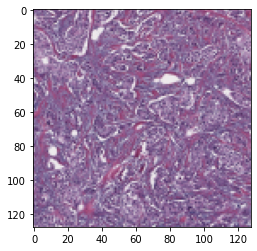

In [4]:
plt.imshow(x_cancer[0].permute(1,2,0), cmap='magma')

In [5]:
# Taken from here https://stackoverflow.com/a/58748125/1983544
num_workers = os.cpu_count() 
if 'sched_getaffinity' in dir(os):
    num_workers = len(os.sched_getaffinity(0))
print (num_workers)

12


In [24]:
x_all = torch.cat((x_cancer, x_healthy))
# probably faster to make extend the list, and then make tensor
y_all = torch.cat((torch.tensor([1]*len(x_cancer)), torch.tensor([0]*len(x_healthy))))
p_all = p_cancer + p_healthy

tensor([1, 1, 1,  ..., 0, 0, 0])

In [17]:
x_train, x_test, y_train, y_test, p_train, p_test = train_test_split(x_all, y_all, p_all, shuffle=True)
x_train, x_val, y_train, y_val, p_train, p_val = train_test_split(x_train, y_train, p_train, shuffle=True)

In [18]:
batch_size = 32
train_dataloader = DataLoader(list(zip(x_train, y_train)),
                              batch_size=batch_size,
                              shuffle=True,
                              num_workers = num_workers)
valid_dataloader = DataLoader(list(zip(x_val, y_val)),
                              batch_size=batch_size,
                              shuffle=False,
                              drop_last=False,
                              num_workers = num_workers)
test_dataloader = DataLoader(x_test,
                             batch_size=batch_size,
                             shuffle=False,
                             drop_last=False,
                             num_workers = num_workers)

In [19]:
loss_fn = nn.CrossEntropyLoss()
learning_rate = 1e-3
lambda_l2 = 1e-4
EPOCHS = 4

In [20]:
seed = 42
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

In [21]:
model_18_ut = timm.create_model('resnet18', pretrained=False, num_classes=2)
print(model_18_ut.fc)

Linear(in_features=512, out_features=2, bias=True)


In [22]:
optimizer = torch.optim.Adam(model_18_ut.fc.parameters(),
                             lr=learning_rate,
                             eps=1e-2,
                             weight_decay=lambda_l2)  # built-in L2

epochs = EPOCHS

In [23]:
model_18_ut = dl_helper.train_epochs(train_dataloader, valid_dataloader, model_18_ut, loss_fn, optimizer, epochs=epochs, log=1)
res_18_ut = dl_helper.test(test_dataloader, model_18_ut)
acc_18_ut = dl_helper.evaluate_pred(y_test, res_18_ut)
print('acc', acc_18_ut)

  0%|          | 0/95 [00:00<?, ?it/s]

/home/jackred/anaconda3/envs/pDL/lib/python3.8/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /tmp/pip-req-build-pma2oi4d/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


validate loss: 0.692296
Epoch 1
-------------------------------


  0%|          | 0/285 [00:00<?, ?it/s]

training loss: 0.671464


  0%|          | 0/95 [00:00<?, ?it/s]

validate loss: 0.687320
Train epoch in 55.0 sec
Epoch 2
-------------------------------


  0%|          | 0/285 [00:00<?, ?it/s]

training loss: 0.684320


  0%|          | 0/95 [00:00<?, ?it/s]

validate loss: 0.683910
Train epoch in 54.9 sec
Epoch 3
-------------------------------


  0%|          | 0/285 [00:00<?, ?it/s]

training loss: 0.686262


  0%|          | 0/95 [00:00<?, ?it/s]

validate loss: 0.678405
Train epoch in 55.1 sec
Epoch 4
-------------------------------


  0%|          | 0/285 [00:00<?, ?it/s]

training loss: 0.713137


  0%|          | 0/95 [00:00<?, ?it/s]

validate loss: 0.674433
Train epoch in 53.9 sec
DONE!
0.7131368517875671


  0%|          | 0/127 [00:00<?, ?it/s]

acc 0.5542913677961909
